In [1]:
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
X = pd.read_csv('hk2_X.csv')
X.shape

(768, 59)

In [4]:
with open('hk2_uncertain_features.txt', 'rb') as fp:
    uncertain_features = pickle.load(fp)

In [5]:
X = X[uncertain_features]

In [6]:
pandas_profiling.ProfileReport(X)

## Correlations

In [7]:
def make_correlation_graphic(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

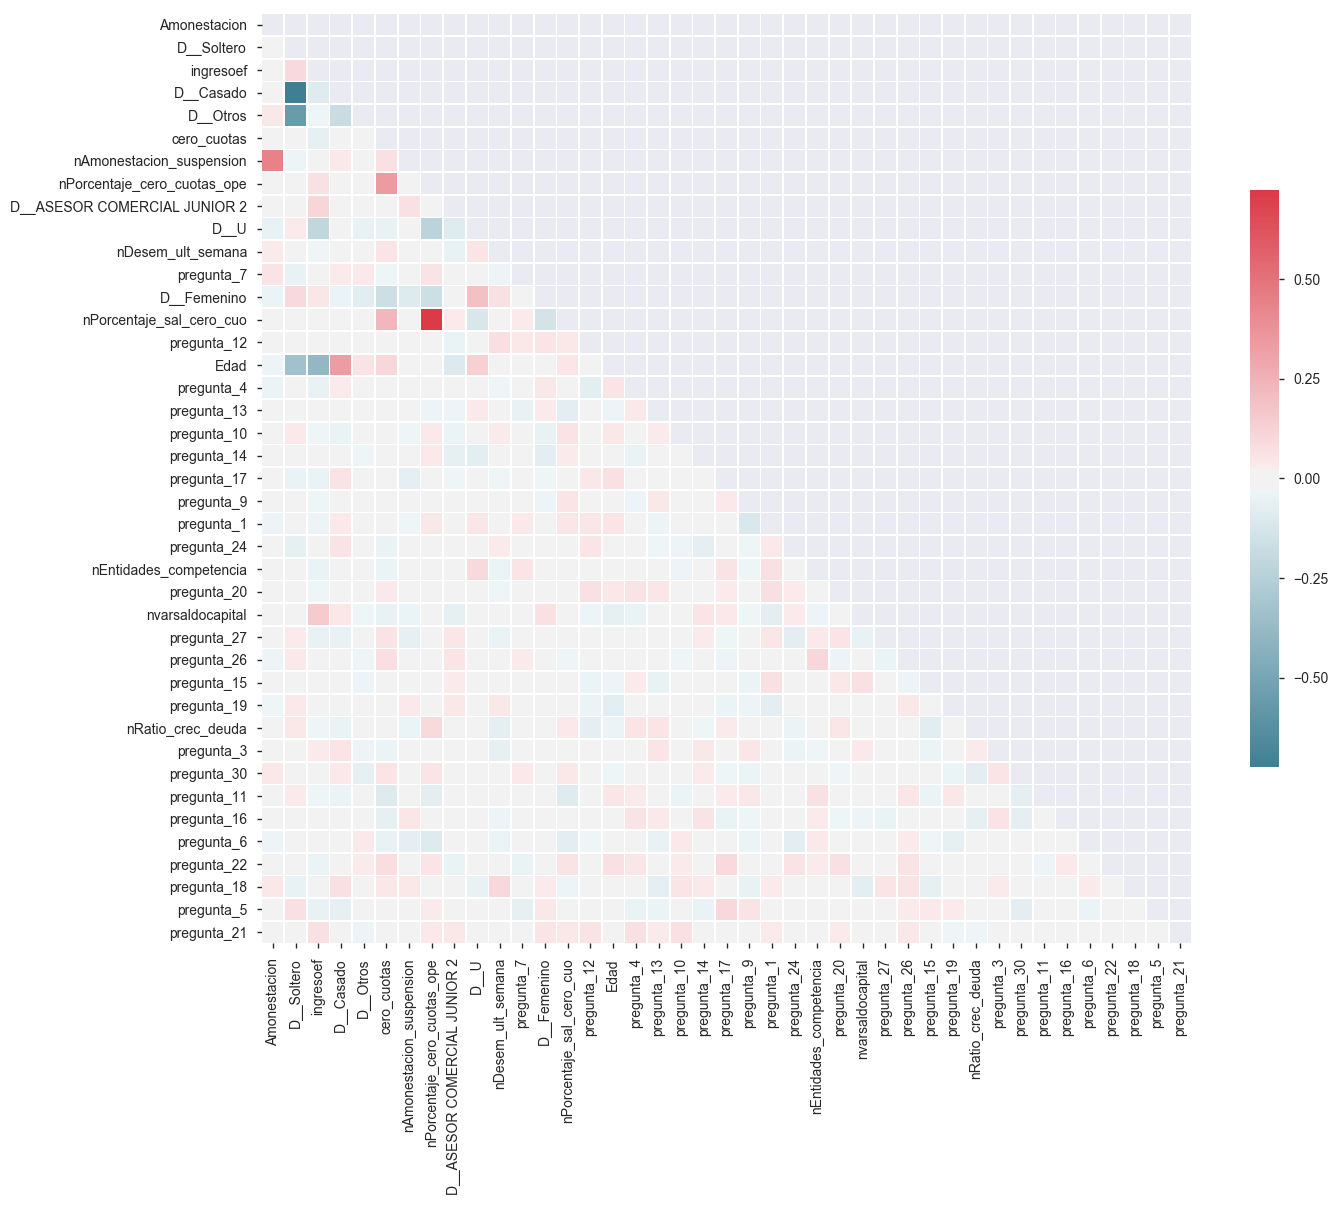

In [8]:
make_correlation_graphic(X)

# Creating target

In [9]:
y = pd.read_csv('hk2_y.csv', header=None)
y.shape

(768, 1)

In [10]:
y.columns = ['TARGET']

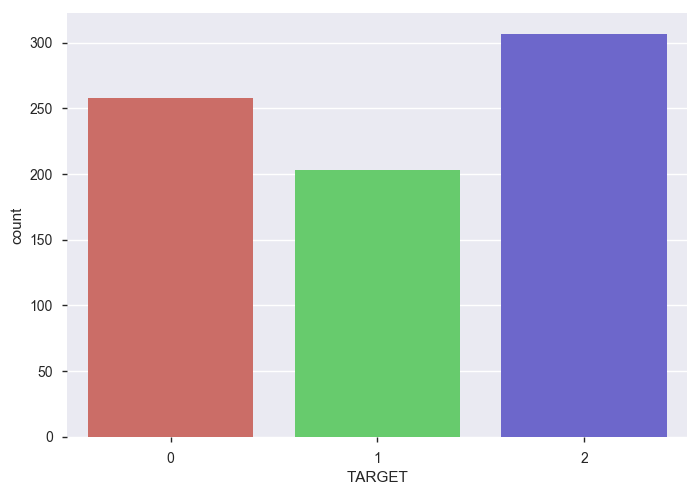

In [11]:
sns.countplot(x="TARGET", data=y, palette='hls')

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

Amonestacion  D__Soltero  ingresoef  D__Casado  D__Otros  cero_cuotas  \
0             0           1          0          0         0            1   
1             0           0          0          0         1            1   
2             0           0          0          1         0            1   
3             0           1          0          0         0            1   
4             0           1          0          0         0            0   

   nAmonestacion_suspension  nPorcentaje_cero_cuotas_ope  \
0                         0                     0.000000   
1                         0                     0.001969   
2                         0                     0.000000   
3                         0                     0.008791   
4                         0                     0.000000   

   D__ASESOR COMERCIAL JUNIOR 2  D__U   ...     pregunta_3  pregunta_30  \
0                             0     1   ...       0.580707     0.856284   
1                             0     1   ...       0.058207     0.953864   
2                             0     1   ...       0.716495     0.614530   
3                             0     1   ...       0.321391     0.982207   
4                             0     1   ...       0.601921     0.121376   

   pregunta_11  pregunta_16  pregunta_6  pregunta_22  pregunta_18  pregunta_5  \
0     0.952996     0.445697    0.208157     0.933387     0.754865    0.191990   
1     0.808606     0.018307    0.939968     0.929419     0.708874    0.871500   
2     0.871213     0.478908    0.528751     0.663385     0.907797    0.286807   
3     0.385427     0.330693    0.035893     0.992835     0.337379    0.645303   
4     0.620596     0.767520    0.913815     0.595219     0.110321    0.926111   

   pregunta_21  cluster  
0     0.155440        1  
1     0.779381       -1  
2     0.444518       -1  
3     0.929461        1  
4     0.386267        1  

[5 rows x 42 columns]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

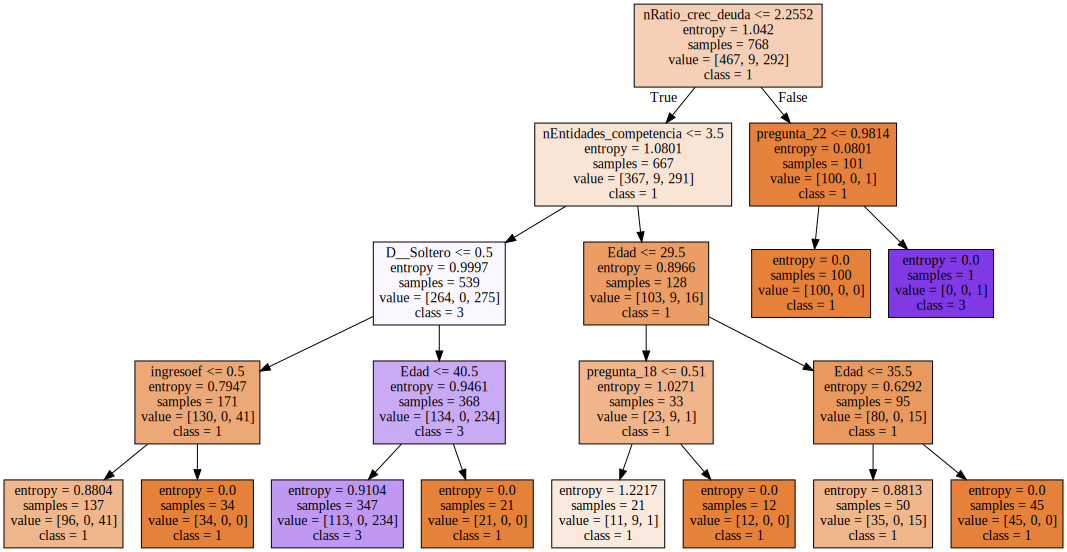

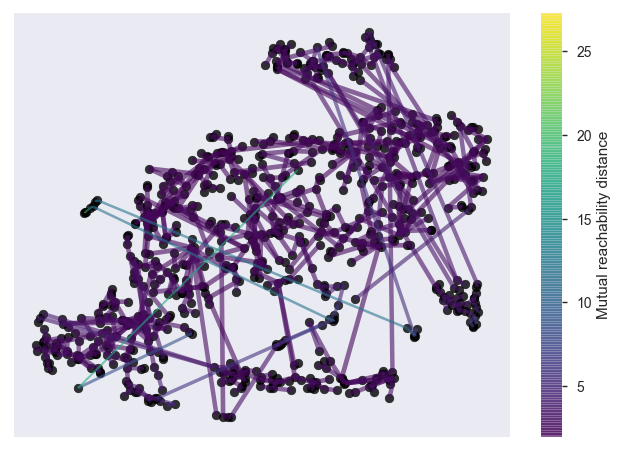

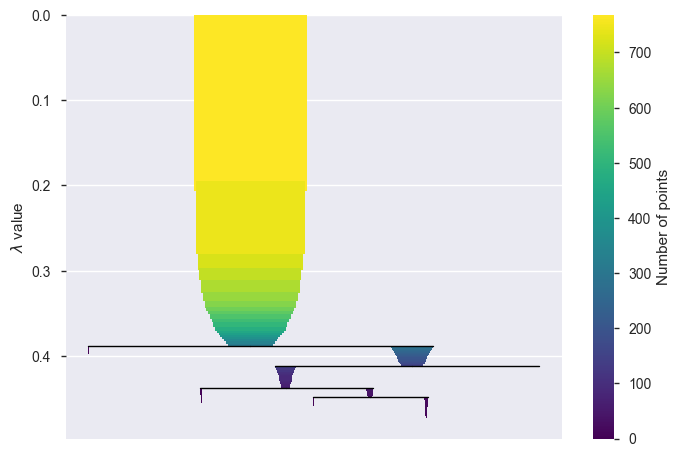

In [12]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

In [13]:
y = y['TARGET']

In [14]:
df = X
df['TARGET'] = y

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Amonestacion  D__Soltero  ingresoef  D__Casado  D__Otros  cero_cuotas  \
1              0           0          0          0         1            1   
3              0           1          0          0         0            1   
6              0           0          0          1         0            1   
12             0           0          0          1         0            0   
13             0           1          0          0         0            1   

    nAmonestacion_suspension  nPorcentaje_cero_cuotas_ope  \
1                          0                     0.001969   
3                          0                     0.008791   
6                          0                     0.010038   
12                         0                     0.000000   
13                         0                     0.000000   

    D__ASESOR COMERCIAL JUNIOR 2  D__U   ...    pregunta_3  pregunta_30  \
1                              0     1   ...      0.058207     0.953864   
3                              0     1   ...      0.321391     0.982207   
6                              0     1   ...      0.042709     0.869502   
12                             0     1   ...      0.645230     0.195945   
13                             0     1   ...      0.738945     0.424003   

    pregunta_11  pregunta_16  pregunta_6  pregunta_22  pregunta_18  \
1      0.808606     0.018307    0.939968     0.929419     0.708874   
3      0.385427     0.330693    0.035893     0.992835     0.337379   
6      0.070039     0.276790    0.387089     0.708068     0.353595   
12     0.614312     0.627501    0.906539     0.862811     0.730291   
13     0.959603     0.918613    0.107369     0.017470     0.851035   

    pregunta_5  pregunta_21  TARGET  
1     0.871500     0.779381       2  
3     0.645303     0.929461       2  
6     0.073125     0.876928       2  
12    0.501630     0.154539       2  
13    0.429477     0.106746       2  

[5 rows x 42 columns]

1     2.0
3    -1.0
6    -1.0
12   -1.0
13   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

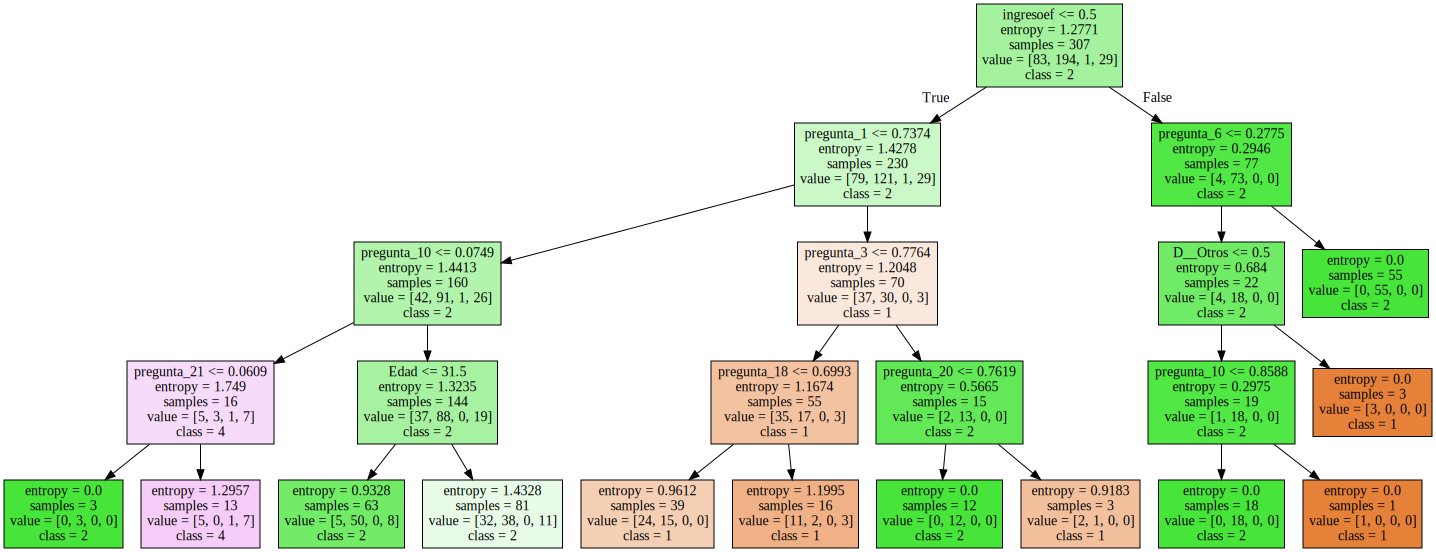

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Amonestacion  D__Soltero  ingresoef  D__Casado  D__Otros  cero_cuotas  \
0              0           1          0          0         0            1   
2              0           0          0          1         0            1   
8              1           0          0          0         1            1   
9              0           1          0          0         0            0   
11             0           0          0          1         0            1   

    nAmonestacion_suspension  nPorcentaje_cero_cuotas_ope  \
0                          0                     0.000000   
2                          0                     0.000000   
8                          1                     0.016685   
9                          0                     0.000000   
11                         0                     0.003868   

    D__ASESOR COMERCIAL JUNIOR 2  D__U   ...    pregunta_3  pregunta_30  \
0                              0     1   ...      0.580707     0.856284   
2                              0     1   ...      0.716495     0.614530   
8                              1     1   ...      0.570358     0.014380   
9                              0     1   ...      0.718091     0.496989   
11                             0     1   ...      0.565522     0.265851   

    pregunta_11  pregunta_16  pregunta_6  pregunta_22  pregunta_18  \
0      0.952996     0.445697    0.208157     0.933387     0.754865   
2      0.871213     0.478908    0.528751     0.663385     0.907797   
8      0.723411     0.298134    0.425821     0.168664     0.984201   
9      0.198031     0.729381    0.259736     0.906333     0.827901   
11     0.850245     0.441747    0.679366     0.409242     0.995752   

    pregunta_5  pregunta_21  TARGET  
0     0.191990     0.155440       0  
2     0.286807     0.444518       0  
8     0.794239     0.786179       0  
9     0.941359     0.211351       0  
11    0.603140     0.261503       0  

[5 rows x 42 columns]

0     2.0
2    -1.0
8    -1.0
9     2.0
11    2.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

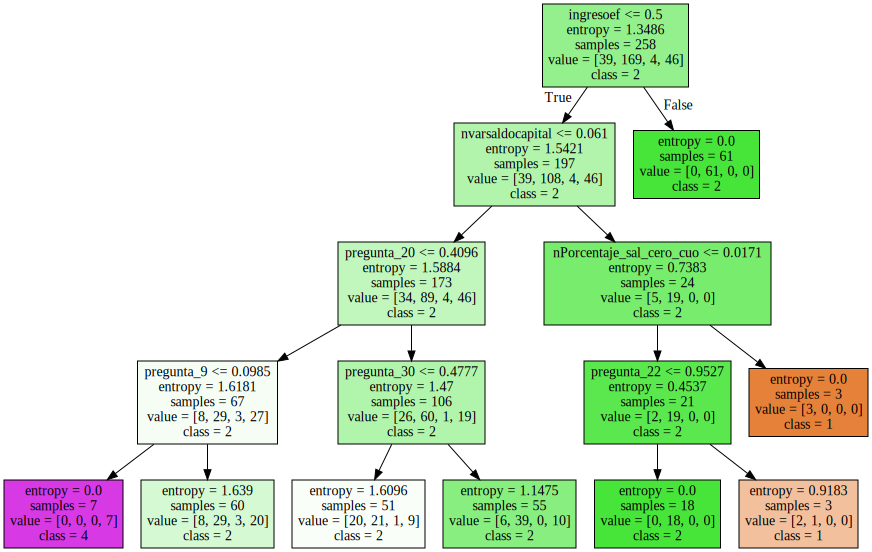

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Amonestacion  D__Soltero  ingresoef  D__Casado  D__Otros  cero_cuotas  \
4              0           1          0          0         0            0   
5              0           1          0          0         0            1   
7              0           1          0          0         0            0   
10             0           1          0          0         0            0   
15             0           1          0          0         0            1   

    nAmonestacion_suspension  nPorcentaje_cero_cuotas_ope  \
4                          0                     0.000000   
5                          0                     0.004474   
7                          0                     0.000000   
10                         0                     0.000000   
15                         0                     0.000000   

    D__ASESOR COMERCIAL JUNIOR 2  D__U   ...    pregunta_3  pregunta_30  \
4                              0     1   ...      0.601921     0.121376   
5                              0     1   ...      0.613986     0.989989   
7                              0     1   ...      0.155432     0.049553   
10                             0     1   ...      0.386503     0.063787   
15                             0     1   ...      0.155241     0.388682   

    pregunta_11  pregunta_16  pregunta_6  pregunta_22  pregunta_18  \
4      0.620596     0.767520    0.913815     0.595219     0.110321   
5      0.196740     0.519179    0.976213     0.479839     0.300183   
7      0.654265     0.478782    0.672811     0.465298     0.424661   
10     0.311577     0.755217    0.706981     0.068633     0.782912   
15     0.337009     0.884526    0.027578     0.873054     0.083542   

    pregunta_5  pregunta_21  TARGET  
4     0.926111     0.386267       1  
5     0.434296     0.576545       1  
7     0.120059     0.172716       1  
10    0.585383     0.431442       1  
15    0.391220     0.076707       1  

[5 rows x 42 columns]

4     2.0
5    -1.0
7     2.0
10    2.0
15   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

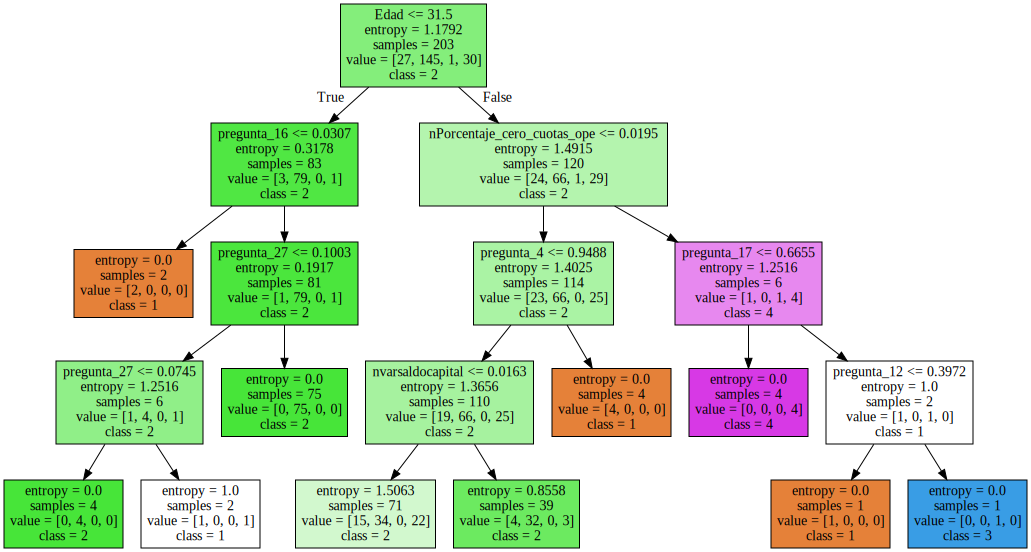

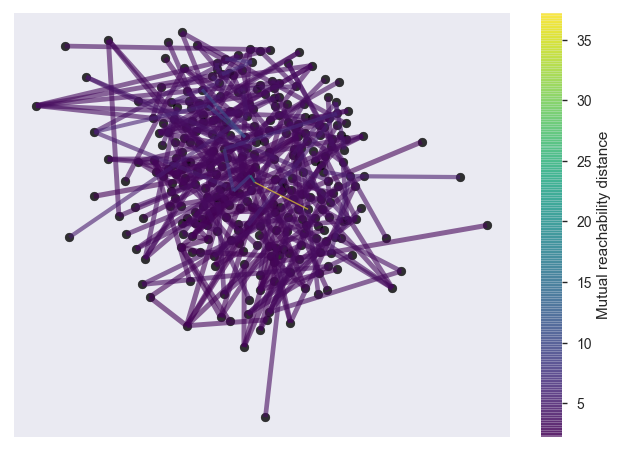

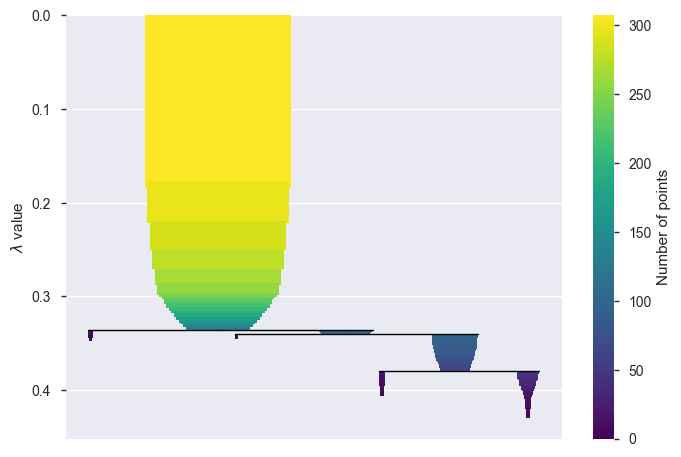

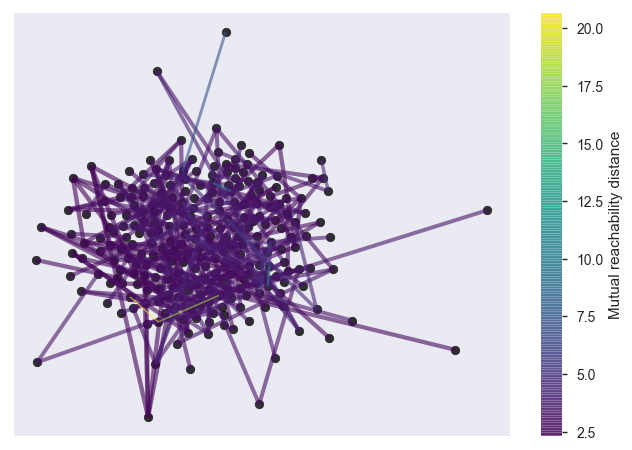

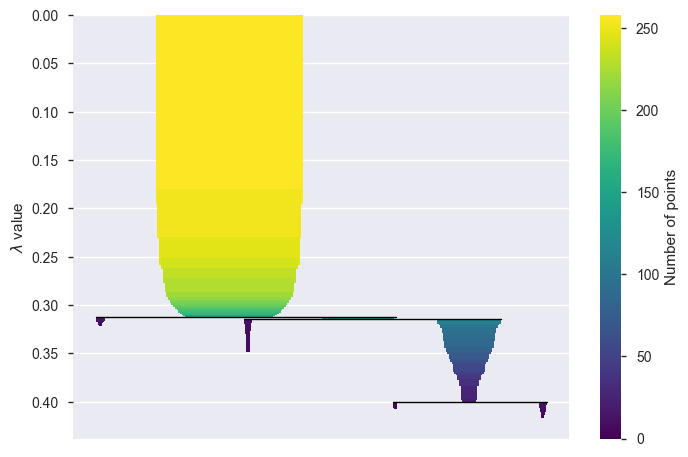

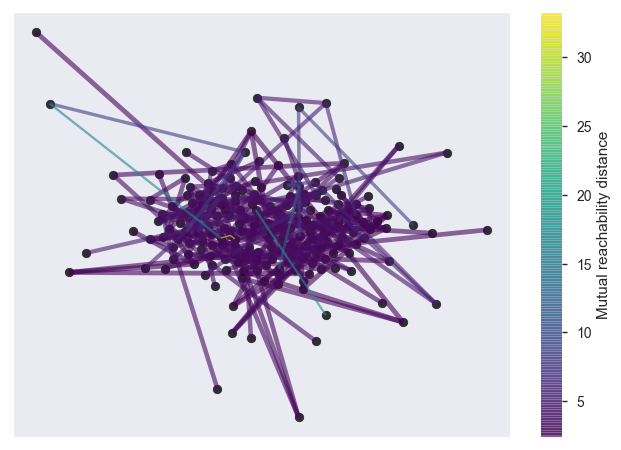

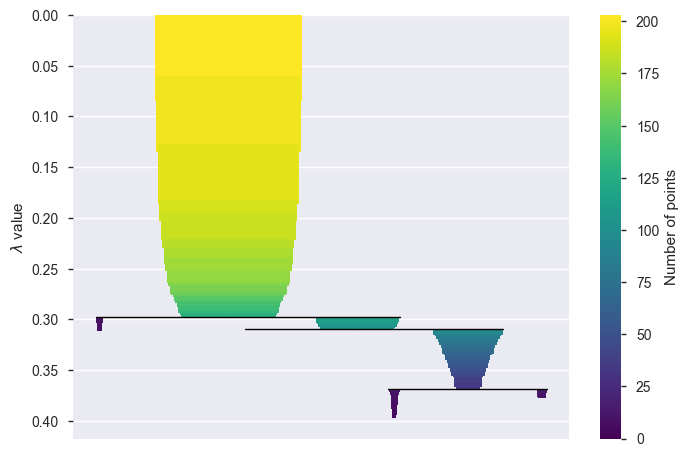

In [15]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

# Cross-validation

In [16]:
X = X.drop('TARGET', axis=1)

In [17]:
X.shape, y.shape

((768, 42), (768,))

In [18]:
eval_size = 0.1
kf = StratifiedKFold(y, round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [19]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 42), (690,))

((78, 42), (78,))

# Models

In [20]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [21]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'is_unbalance': True,
 'learning_rate': 0.03,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 8,
 'objective': 'multiclass',
 'reg_alpha': 0.5,
 'reg_lambda': 6,
 'seed': 777,
 'subsample': 0.6}

Recall: 0.7419354838709677
Precision: 0.40350877192982454
Accuracy: 0.358974358974359


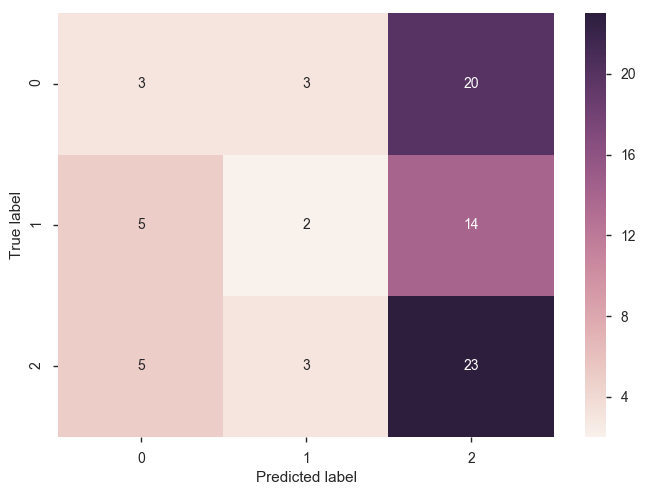

In [22]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09742
[2]	valid_0's multi_logloss: 1.09632
[3]	valid_0's multi_logloss: 1.09492
[4]	valid_0's multi_logloss: 1.09355
[5]	valid_0's multi_logloss: 1.09265
[6]	valid_0's multi_logloss: 1.09352
[7]	valid_0's multi_logloss: 1.09308
[8]	valid_0's multi_logloss: 1.0939
[9]	valid_0's multi_logloss: 1.09262
[10]	valid_0's multi_logloss: 1.09177
[11]	valid_0's multi_logloss: 1.09233
[12]	valid_0's multi_logloss: 1.09175
[13]	valid_0's multi_logloss: 1.09225
[14]	valid_0's multi_logloss: 1.0917
[15]	valid_0's multi_logloss: 1.09156
[16]	valid_0's multi_logloss: 1.09129
[17]	valid_0's multi_logloss: 1.08986
[18]	valid_0's multi_logloss: 1.0896
[19]	valid_0's multi_logloss: 1.08922
[20]	valid_0's multi_logloss: 1.08921
[21]	valid_0's multi_logloss: 1.08955
[22]	valid_0's multi_logloss: 1.08909
[23]	valid_0's multi_logloss: 1.08866
[24]	valid_0's multi_logloss: 1.08967
[25]	valid_0's multi_logloss: 1.08879
[26]	valid_0's multi_logloss: 1.08886
[27]	valid_0's multi_log

Recall: 0.5806451612903226
Precision: 0.4
Accuracy: 0.34615384615384615


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


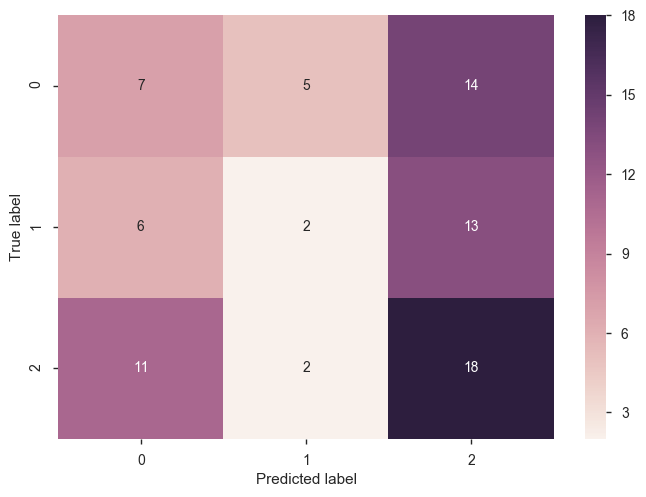

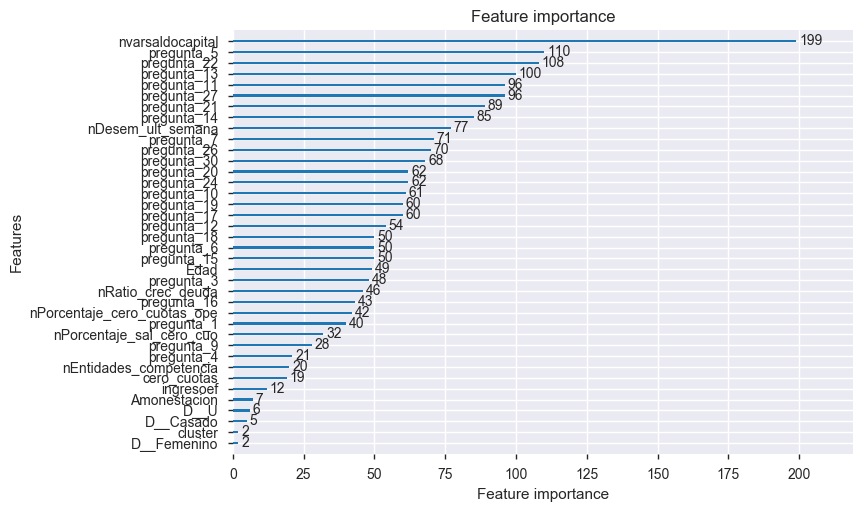

In [23]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 120}

Recall: 0.8064516129032258
Precision: 0.43103448275862066
Accuracy: 0.3974358974358974


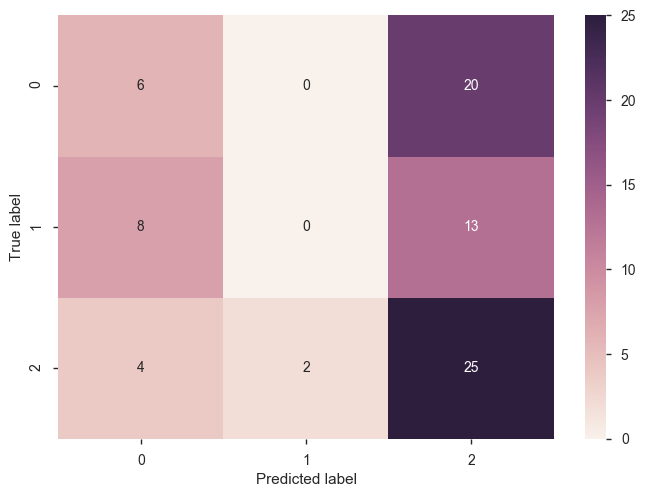

In [24]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.8064516129032258
Precision: 0.43103448275862066
Accuracy: 0.3974358974358974
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


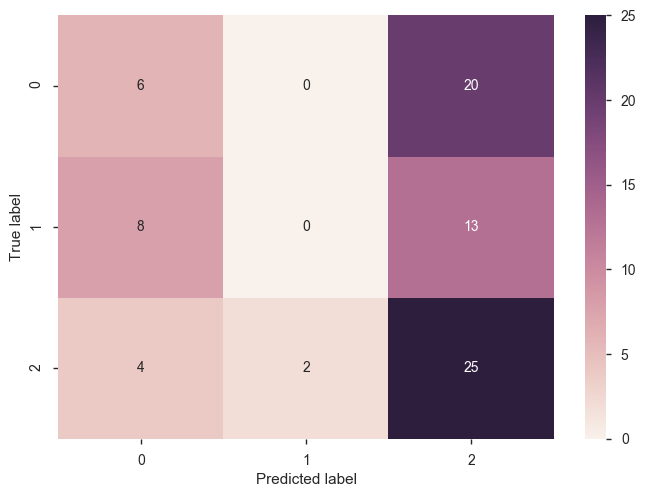

In [25]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 120}

Recall: 0.8387096774193549
Precision: 0.4482758620689655
Accuracy: 0.4230769230769231


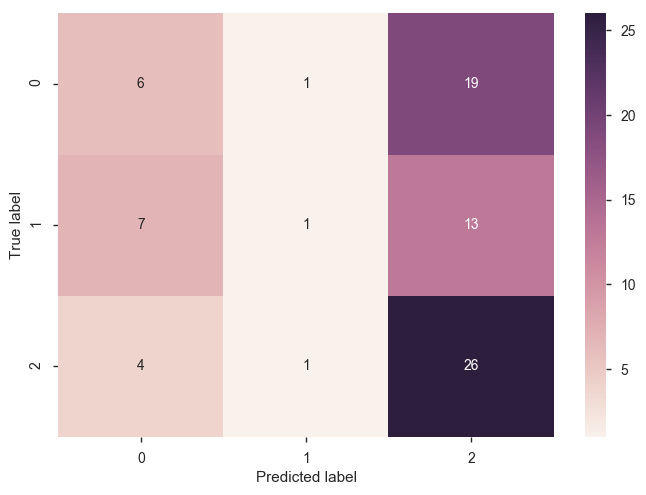

In [26]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.8387096774193549
Precision: 0.4482758620689655
Accuracy: 0.4230769230769231
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


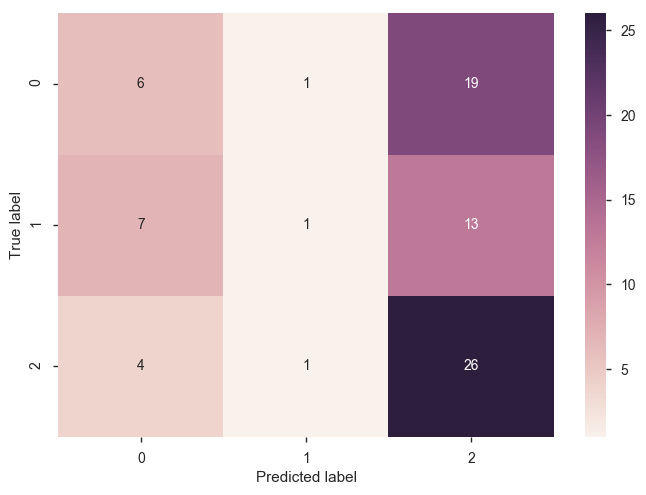

In [27]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### Garbage collection

In [29]:
del DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomizedSearchCV, RFE, SVG, Source, StratifiedKFold
del X, y, X_cluster, X_target, X_train, X_valid, accuracy, accuracy_score, clf, cluster_colors, clusterer, cm
del confusion_matrix, d, d_train, d_valid, dtc
del estimator, eval_size, export_graphviz, f1_score, fe_entropy, fe_rfe, g, graph, hdbscan
del kf, lgb, make_correlation_graphic, model, pandas_profiling, param_grid
del precision, precision_score, recall, recall_score, row, selector, target_class, train_ix, valid_ix, y_cluster, y_pred
del y_pred_trunc, y_train, y_valid
collect()

302

# Results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


entropy  rfe  N_entropy     N_rfe     score
cero_cuotas                   0.053465   27   0.328624  0.195760  0.524385
cluster                       0.030183   31   0.185521  0.224762  0.410282
D__ASESOR COMERCIAL JUNIOR 2  0.028163   32   0.173105  0.232012  0.405117
D__Femenino                   0.024088   33   0.148055  0.239262  0.387318
ingresoef                     0.026094   30   0.160386  0.217511  0.377897
D__U                          0.018357   35   0.112834  0.253763  0.366597
D__Casado                     0.016963   36   0.104262  0.261014  0.365275
pregunta_3                    0.027320   26   0.167925  0.188510  0.356435
nAmonestacion_suspension      0.017247   34   0.106009  0.246513  0.352522
pregunta_11                   0.026820   25   0.164847  0.181259  0.346107
D__Otros                      0.011518   37   0.070797  0.268264  0.339060
Amonestacion                  0.007910   38   0.048618  0.275514  0.324133
nEntidades_competencia        0.024354   23   0.149691  0.166759  0.316450
pregunta_13                   0.028929   19   0.177813  0.137757  0.315570
D__Soltero                    0.017812   28   0.109482  0.203011  0.312493
pregunta_27                   0.035071   12   0.215564  0.087005  0.302569
pregunta_16                   0.025076   20   0.154127  0.145008  0.299135
nPorcentaje_cero_cuotas_ope   0.014075   29   0.086512  0.210261  0.296772
pregunta_1                    0.021623   22   0.132906  0.159508  0.292415
pregunta_24                   0.022362   21   0.137448  0.152258  0.289706
pregunta_9                    0.025048   17   0.153956  0.123256  0.277212
pregunta_15                   0.026384   15   0.162171  0.108756  0.270926
pregunta_19                   0.022213   18   0.136533  0.130507  0.267040
pregunta_26                   0.026354   14   0.161982  0.101505  0.263488
pregunta_30                   0.029078    8   0.178730  0.058003  0.236733
nPorcentaje_sal_cero_cuo      0.009128   24   0.056106  0.174009  0.230115
pregunta_6                    0.025605   10   0.157378  0.072504  0.229882
pregunta_14                   0.024136   11   0.148353  0.079754  0.228107
pregunta_10                   0.026307    9   0.161697  0.065253  0.226951
Edad                          0.016530   16   0.101602  0.116006  0.217608
pregunta_7                    0.028639    5   0.176028  0.036252  0.212280
pregunta_20                   0.026219    7   0.161155  0.050753  0.211908
pregunta_17                   0.026999    6   0.165947  0.043502  0.209449
pregunta_18                   0.028729    3   0.176581  0.021751  0.198332
pregunta_5                    0.030438    1   0.187087  0.007250  0.194337
pregunta_4                    0.025141    4   0.154529  0.029002  0.183531
pregunta_22                   0.028610    1   0.175851  0.007250  0.183101
pregunta_12                   0.027076    2   0.166425  0.014501  0.180926
pregunta_21                   0.026971    1   0.165780  0.007250  0.173030
nvarsaldocapital              0.020780    1   0.127726  0.007250  0.134977
nRatio_crec_deuda             0.005199   13   0.031957  0.094255  0.126212
nDesem_ult_semana             0.016985    1   0.104399  0.007250  0.111649

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

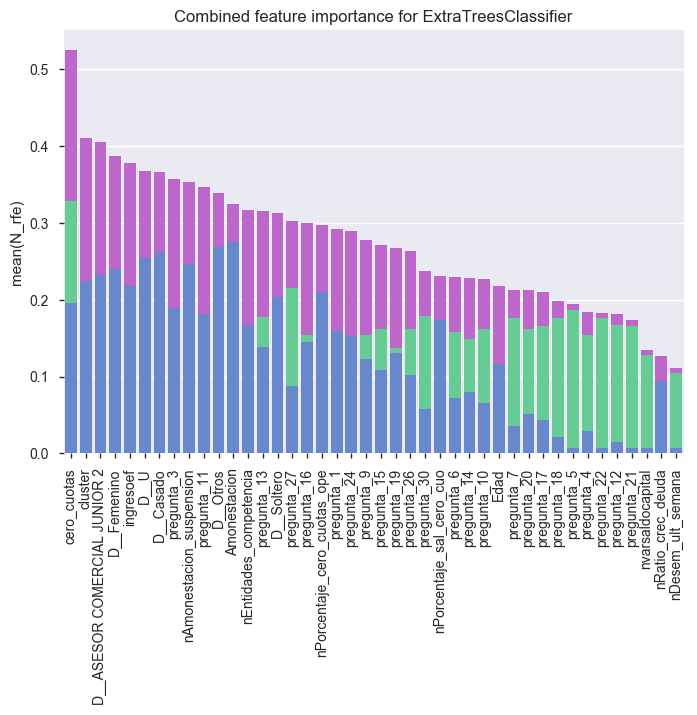

In [30]:
df1 = pd.DataFrame(model_results['extra_trees']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['extra_trees']['fe_rfe']).set_index(0)
results_extra_trees = pd.concat([df1, df2], axis=1)

results_extra_trees.columns = ['entropy', 'rfe']
results_extra_trees['N_entropy'] = normalize(results_extra_trees['entropy'])[0]
results_extra_trees['N_rfe'] = normalize(results_extra_trees['rfe'])[0]

results_extra_trees['score'] = results_extra_trees['N_entropy'] + results_extra_trees['N_rfe']

results_extra_trees = results_extra_trees.sort_values('score', ascending=False)

results_extra_trees

plt.title('Combined feature importance for ExtraTreesClassifier')
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


entropy  rfe  N_entropy     N_rfe     score
nvarsaldocapital              0.081657    1   0.441673  0.007250  0.448923
nDesem_ult_semana             0.033086   22   0.178958  0.159508  0.338467
pregunta_6                    0.031433   23   0.170016  0.166759  0.336775
nRatio_crec_deuda             0.027526   24   0.148884  0.174009  0.322893
pregunta_14                   0.043237   12   0.233864  0.087005  0.320869
pregunta_3                    0.030386   21   0.164356  0.152258  0.316614
nPorcentaje_sal_cero_cuo      0.022505   26   0.121726  0.188510  0.310236
nPorcentaje_cero_cuotas_ope   0.020420   25   0.110447  0.181259  0.291706
D__Casado                     0.002452   38   0.013263  0.275514  0.288777
pregunta_10                   0.031518   16   0.170476  0.116006  0.286482
pregunta_17                   0.032788   15   0.177346  0.108756  0.286102
pregunta_24                   0.028677   18   0.155110  0.130507  0.285616
pregunta_18                   0.025186   20   0.136230  0.145008  0.281238
pregunta_12                   0.028297   17   0.153054  0.123256  0.276310
D__Soltero                    0.002793   36   0.015109  0.261014  0.276123
Amonestacion                  0.000744   37   0.004027  0.268264  0.272291
D__Femenino                   0.002299   35   0.012434  0.253763  0.266197
pregunta_13                   0.031547   13   0.170635  0.094255  0.264890
nEntidades_competencia        0.012757   27   0.069002  0.195760  0.264762
Edad                          0.023111   19   0.125004  0.137757  0.262762
cero_cuotas                   0.009507   29   0.051421  0.210261  0.261682
D__U                          0.001931   34   0.010446  0.246513  0.256959
pregunta_9                    0.028393   14   0.153577  0.101505  0.255082
pregunta_27                   0.045110    1   0.243993  0.007250  0.251243
D__ASESOR COMERCIAL JUNIOR 2  0.004345   31   0.023503  0.224762  0.248265
D__Otros                      0.001472   33   0.007961  0.239262  0.247223
ingresoef                     0.002267   32   0.012262  0.232012  0.244274
pregunta_5                    0.042300    1   0.228798  0.007250  0.236048
pregunta_4                    0.029448   10   0.159282  0.072504  0.231786
nAmonestacion_suspension      0.001860   30   0.010058  0.217511  0.227570
cluster                       0.003894   28   0.021064  0.203011  0.224075
pregunta_30                   0.035825    4   0.193773  0.029002  0.222775
pregunta_1                    0.026356   11   0.142557  0.079754  0.222311
pregunta_15                   0.029390    7   0.158965  0.050753  0.209718
pregunta_11                   0.025729    9   0.139165  0.065253  0.204418
pregunta_16                   0.029682    6   0.160548  0.043502  0.204050
pregunta_26                   0.029804    5   0.161208  0.036252  0.197459
pregunta_22                   0.034398    1   0.186056  0.007250  0.193306
pregunta_20                   0.023279    8   0.125911  0.058003  0.183914
pregunta_21                   0.029466    1   0.159377  0.007250  0.166627
pregunta_7                    0.028121    2   0.152103  0.014501  0.166604
pregunta_19                   0.025004    3   0.135246  0.021751  0.156997

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

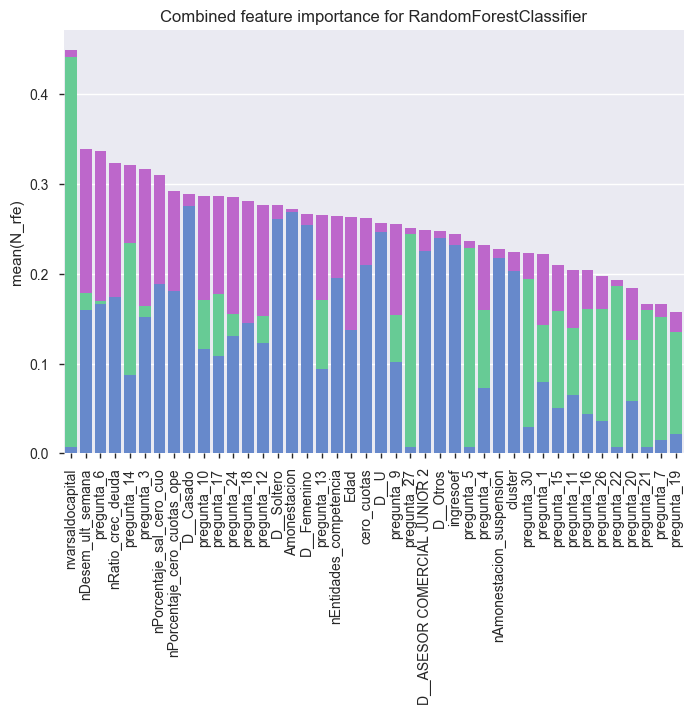

In [31]:
df1 = pd.DataFrame(model_results['random_forest']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['random_forest']['fe_rfe']).set_index(0)
results_random_forest = pd.concat([df1, df2], axis=1)

results_random_forest.columns = ['entropy', 'rfe']
results_random_forest['N_entropy'] = normalize(results_random_forest['entropy'])[0]
results_random_forest['N_rfe'] = normalize(results_random_forest['rfe'])[0]

results_random_forest['score'] = results_random_forest['N_entropy'] + results_random_forest['N_rfe']

results_random_forest = results_random_forest.sort_values('score', ascending=False)

results_random_forest

plt.title('Combined feature importance for RandomForestClassifier')
sns.barplot(x=results_random_forest.index, y=results_random_forest['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

0  nvarsaldocapital  pregunta_5  pregunta_22  pregunta_13  pregunta_27  \
1               199         110          108          100           96   

0  pregunta_11  pregunta_21  pregunta_14  nDesem_ult_semana  pregunta_7  \
1           96           89           85                 77          71   

0              ...               ingresoef  Amonestacion  D__U  D__Casado  \
1              ...                      12             7     6          5   

0  D__Femenino  cluster  D__Soltero  D__Otros  nAmonestacion_suspension  \
1            2        2           0         0                         0   

0  D__ASESOR_COMERCIAL_JUNIOR_2  
1                             0  

[1 rows x 42 columns]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


entropy  rfe  N_entropy     N_rfe     score
nvarsaldocapital                  199    1   0.480156  0.007250  0.487406
pregunta_13                       100   13   0.241284  0.094255  0.335539
pregunta_27                        96   14   0.231633  0.101505  0.333138
pregunta_5                        110    8   0.265413  0.058003  0.323416
pregunta_26                        70   21   0.168899  0.152258  0.321157
pregunta_11                        96   12   0.231633  0.087005  0.318637
pregunta_7                         71   19   0.171312  0.137757  0.309069
nDesem_ult_semana                  77   17   0.185789  0.123256  0.309045
Edad                               49   26   0.118229  0.188510  0.306739
nPorcentaje_cero_cuotas_ope        42   27   0.101339  0.195760  0.297099
pregunta_21                        89   11   0.214743  0.079754  0.294497
D__Casado                           5   38   0.012064  0.275514  0.287578
pregunta_22                       108    3   0.260587  0.021751  0.282338
D__U                                6   36   0.014477  0.261014  0.275491
D__Otros                            0   37   0.000000  0.268264  0.268264
pregunta_3                         48   20   0.115816  0.145008  0.260824
pregunta_19                        60   16   0.144771  0.116006  0.260777
cero_cuotas                        19   29   0.045844  0.210261  0.256105
pregunta_1                         40   22   0.096514  0.159508  0.256022
pregunta_10                        61   15   0.147183  0.108756  0.255939
D__ASESOR COMERCIAL JUNIOR 2        0   35   0.000000  0.253763  0.253763
pregunta_18                        50   18   0.120642  0.130507  0.251149
Amonestacion                        7   32   0.016890  0.232012  0.248902
pregunta_9                         28   25   0.067560  0.181259  0.248819
D__Soltero                          0   34   0.000000  0.246513  0.246513
nPorcentaje_sal_cero_cuo           32   23   0.077211  0.166759  0.243970
nAmonestacion_suspension            0   33   0.000000  0.239262  0.239262
ingresoef                          12   28   0.028954  0.203011  0.231965
D__Femenino                         2   31   0.004826  0.224762  0.229587
cluster                             2   30   0.004826  0.217511  0.222337
nEntidades_competencia             20   24   0.048257  0.174009  0.222266
pregunta_17                        60   10   0.144771  0.072504  0.217274
pregunta_30                        68    7   0.164073  0.050753  0.214826
pregunta_14                        85    1   0.205092  0.007250  0.212342
pregunta_6                         50    9   0.120642  0.065253  0.185895
pregunta_24                        62    5   0.149596  0.036252  0.185848
pregunta_12                        54    6   0.130293  0.043502  0.173796
pregunta_20                        62    1   0.149596  0.007250  0.156847
pregunta_15                        50    4   0.120642  0.029002  0.149644
pregunta_16                        43    2   0.103752  0.014501  0.118253
nRatio_crec_deuda                  46    1   0.110991  0.007250  0.118241
pregunta_4                         21    1   0.050670  0.007250  0.057920

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

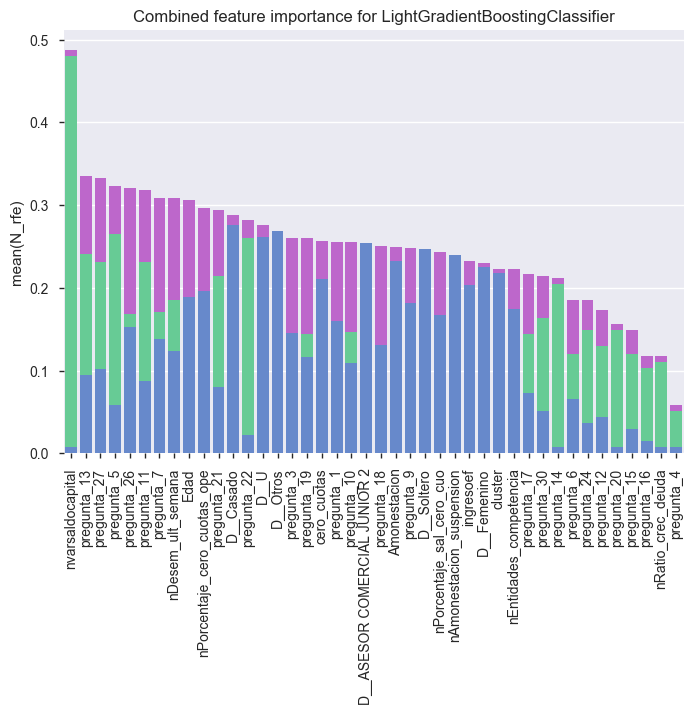

In [32]:
df1 = pd.DataFrame(model_results['lightgbm']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['lightgbm']['fe_rfe']).set_index(0)

df1 = df1.T
df1

for feature in [col for col in df1.columns if col.startswith('D_')]:
    df1 = df1.rename(columns={
        feature: feature.replace('_', ' ').replace('D  ', 'D__')
    })

df1 = df1.T
    
results_lightgbm = pd.concat([df1, df2], axis=1)

results_lightgbm.columns = ['entropy', 'rfe']
results_lightgbm['N_entropy'] = normalize(results_lightgbm['entropy'])[0]
results_lightgbm['N_rfe'] = normalize(results_lightgbm['rfe'])[0]

results_lightgbm['score'] = results_lightgbm['N_entropy'] + results_lightgbm['N_rfe']

results_lightgbm = results_lightgbm.sort_values('score', ascending=False)

results_lightgbm

plt.title('Combined feature importance for LightGradientBoostingClassifier')
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

extra_trees  random_forest  lightgbm     score
nvarsaldocapital                 0.134977       0.448923  0.487406  1.071306
cero_cuotas                      0.524385       0.261682  0.256105  1.042172
D__Casado                        0.365275       0.288777  0.287578  0.941631
pregunta_3                       0.356435       0.316614  0.260824  0.933873
pregunta_13                      0.315570       0.264890  0.335539  0.915999
D__ASESOR COMERCIAL JUNIOR 2     0.405117       0.248265  0.253763  0.907145
D__U                             0.366597       0.256959  0.275491  0.899046
pregunta_27                      0.302569       0.251243  0.333138  0.886950
nPorcentaje_cero_cuotas_ope      0.296772       0.291706  0.297099  0.885578
D__Femenino                      0.387318       0.266197  0.229587  0.883102
pregunta_11                      0.346107       0.204418  0.318637  0.869162
cluster                          0.410282       0.224075  0.222337  0.856694
D__Otros                         0.339060       0.247223  0.268264  0.854547
ingresoef                        0.377897       0.244274  0.231965  0.854137
Amonestacion                     0.324133       0.272291  0.248902  0.845325
D__Soltero                       0.312493       0.276123  0.246513  0.835128
nAmonestacion_suspension         0.352522       0.227570  0.239262  0.819354
nEntidades_competencia           0.316450       0.264762  0.222266  0.803478
Edad                             0.217608       0.262762  0.306739  0.787109
nPorcentaje_sal_cero_cuo         0.230115       0.310236  0.243970  0.784320
pregunta_26                      0.263488       0.197459  0.321157  0.782104
pregunta_9                       0.277212       0.255082  0.248819  0.781113
pregunta_1                       0.292415       0.222311  0.256022  0.770747
pregunta_10                      0.226951       0.286482  0.255939  0.769372
pregunta_14                      0.228107       0.320869  0.212342  0.761318
pregunta_24                      0.289706       0.285616  0.185848  0.761170
nDesem_ult_semana                0.111649       0.338467  0.309045  0.759161
pregunta_5                       0.194337       0.236048  0.323416  0.753801
pregunta_6                       0.229882       0.336775  0.185895  0.752552
pregunta_18                      0.198332       0.281238  0.251149  0.730719
pregunta_17                      0.209449       0.286102  0.217274  0.712825
pregunta_7                       0.212280       0.166604  0.309069  0.687952
pregunta_19                      0.267040       0.156997  0.260777  0.684813
pregunta_30                      0.236733       0.222775  0.214826  0.674334
pregunta_22                      0.183101       0.193306  0.282338  0.658746
pregunta_21                      0.173030       0.166627  0.294497  0.634154
pregunta_12                      0.180926       0.276310  0.173796  0.631031
pregunta_15                      0.270926       0.209718  0.149644  0.630287
pregunta_16                      0.299135       0.204050  0.118253  0.621438
nRatio_crec_deuda                0.126212       0.322893  0.118241  0.567346
pregunta_20                      0.211908       0.183914  0.156847  0.552669
pregunta_4                       0.183531       0.231786  0.057920  0.473236

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

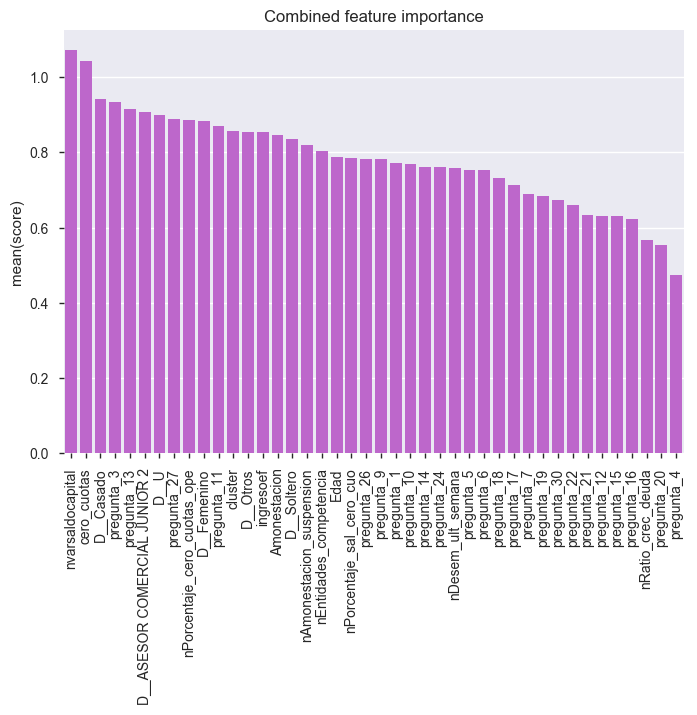

In [33]:
df_results = pd.concat([results_extra_trees['score'], results_random_forest['score'], results_lightgbm['score']], axis=1)
df_results.columns = ['extra_trees', 'random_forest', 'lightgbm']
df_results['score'] = df_results['extra_trees'] + df_results['random_forest'] + df_results['lightgbm']

df_results = df_results.sort_values('score', ascending=False)

df_results

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[4])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

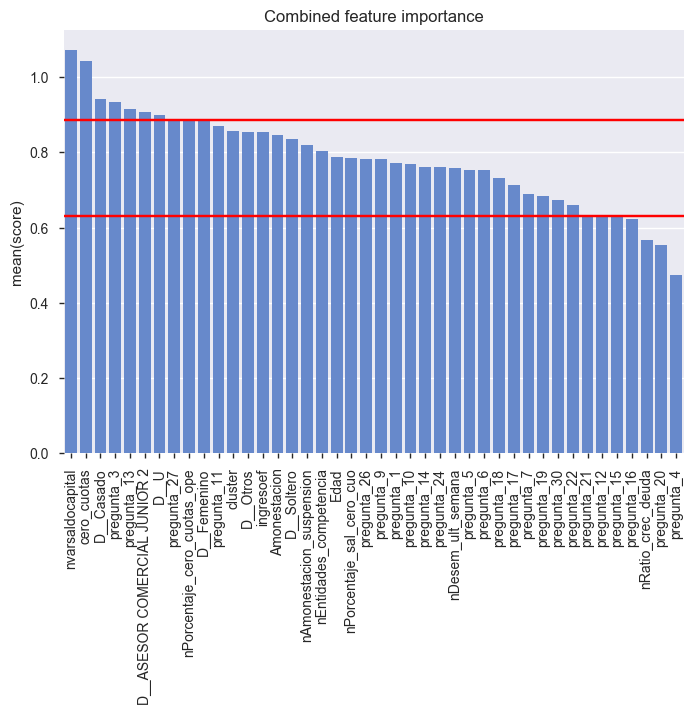

In [34]:
margin1 = 0.1
margin2 = 0.8

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)
sns.plt.axhline(df_results['score'].quantile(margin1), color='r')
sns.plt.axhline(df_results['score'].quantile(margin2), color='r')

In [35]:
categories = ['bad_uncertain', 'uncertain', 'good_uncertain']
cuts = [
    min(df_results['score']), 
    df_results['score'].quantile(margin1), 
    df_results['score'].quantile(margin2), 
    max(df_results['score'])
]
df_results['score'] = pd.cut(df_results['score'], cuts, labels=categories, include_lowest=True)
df_results['score']

nvarsaldocapital                good_uncertain
cero_cuotas                     good_uncertain
D__Casado                       good_uncertain
pregunta_3                      good_uncertain
pregunta_13                     good_uncertain
D__ASESOR COMERCIAL JUNIOR 2    good_uncertain
D__U                            good_uncertain
pregunta_27                     good_uncertain
nPorcentaje_cero_cuotas_ope     good_uncertain
D__Femenino                          uncertain
pregunta_11                          uncertain
cluster                              uncertain
D__Otros                             uncertain
ingresoef                            uncertain
Amonestacion                         uncertain
D__Soltero                           uncertain
nAmonestacion_suspension             uncertain
nEntidades_competencia               uncertain
Edad                                 uncertain
nPorcentaje_sal_cero_cuo             uncertain
pregunta_26                          uncertain
pregunta_9   

In [36]:
df_results.to_csv('hk2_uncertain_pass_results.csv')